## Analysis of CXCR3+ memory B cells in twins discordant for MS

In [1]:
library(dplyr)
library(ggplot2)
library(ggrepel)
library(purrr)
library(tidyr)
library(ggthemes)
library(tibble)
library(destiny)
library(coin)
library(rstatix)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd("/home/labs/amit/floriani/Lab/PROJECTS/MS/Twins/reports/2023-02-08_B_cells_MS_twins")
source("/home/labs/amit/floriani/Lab/ORGANIZATION/utility functions/2022-12-15_sc_utility.R")

# load data and inspect

In [3]:
# load full data
load("../../data/surface/processed/data_main_clust_k6.RDa")
data_full  <- data_clustered
sample_counts  <- data_full %>% data.frame %>% group_by(sample_id) %>% summarize(total_count = n())

# load B cell data
load("../../data/surface/processed/data_b_cells_clust_k6.RDa")

md  <- openxlsx::read.xlsx("../../data/surface/meta/meta_twins.xlsx")

# run umap and flowsom clustering


In [4]:
# subsample balanced
n_samples  <- data_clustered[,"sample_id"] %>% unique
data_sub <- data.frame(NULL)
n_sub_i <- 100
for(i in n_samples){
      data_i <- data_clustered[data_clustered[,"sample_id"]==i,]
      n_i <- nrow(data_i)
      set.seed(123)
      if(n_sub_i > n_i){
        ix_i <- sample(1:n_i, n_i)
      }
      else{
        ix_i <- sample(1:n_i, n_sub_i)
      }
      data_sub_i <- data_i[ix_i,]
      data_sub <- rbind(data_sub, data_sub_i)
}

In [ ]:
# umap
umap_cols  <- c("IgD", "CXCR3", "CD27", "IgM")

# UMAP
data_umap <-  umap::umap(data_sub[,umap_cols], random_state=123, verbose =T)
umap <- as.data.frame(data_umap$layout) %>% rename("UMAP1" = 1, "UMAP2" = 2)


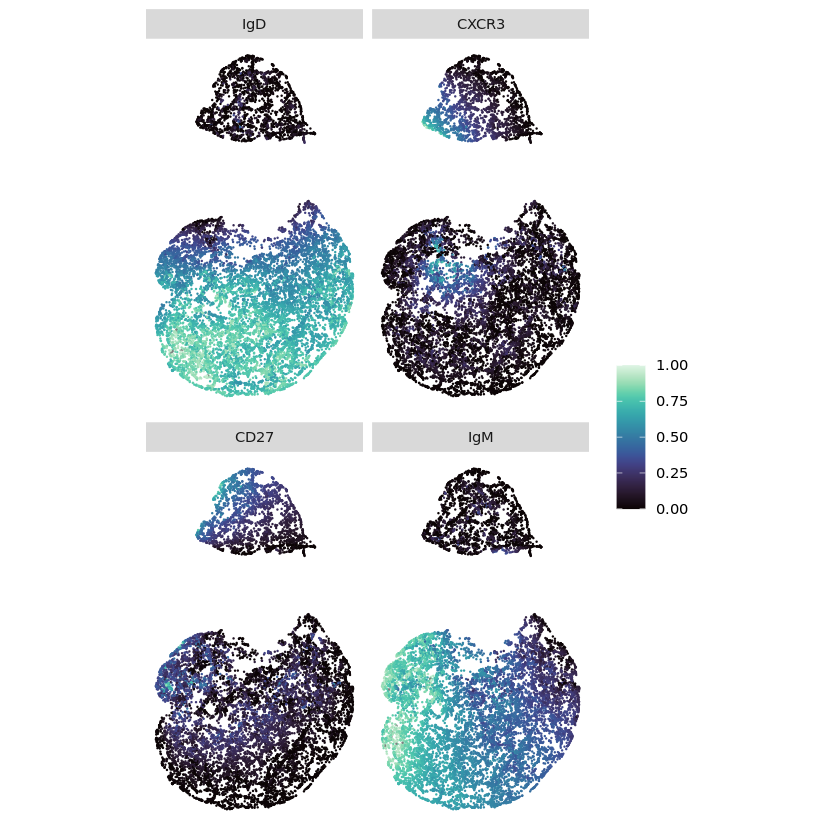

In [9]:
# prepare the expression data
umap_plot <- data_sub[,umap_cols] %>% mutate(UMAP1 = umap$UMAP1, UMAP2 = umap$UMAP2) %>% reshape2::melt(id.vars = c("UMAP1", "UMAP2"))

# plot UMAP with expression overlayed
pl_umap_overlay <- ggplot(umap_plot, aes(x = UMAP1, y = UMAP2, color = value)) +
  geom_point(size = 0.05) +
  coord_fixed(ratio = 1) +
  scale_colour_gradientn(colours = viridis::mako(100), limits = c(0,1)) +
  facet_wrap(~ variable, ncol = 2) +
  theme_very_few +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())
pl_umap_overlay

In [10]:
# FlowSOM
ff <- flowCore::flowFrame(exprs = data_clustered, desc = list(FIL = 1))

set.seed(123)
fSOM <- FlowSOM::FlowSOM(ff, compensate = FALSE, transform = FALSE, scale = FALSE,
                 colsToUse = umap_cols, xdim = 10, ydim = 10, nClus = 10)

data_clustered_df  <- data_clustered %>% data.frame %>% mutate(b_cell_clust_new = FlowSOM::GetMetaclusters(fSOM))              

Joining with `by = join_by(cell_id)`


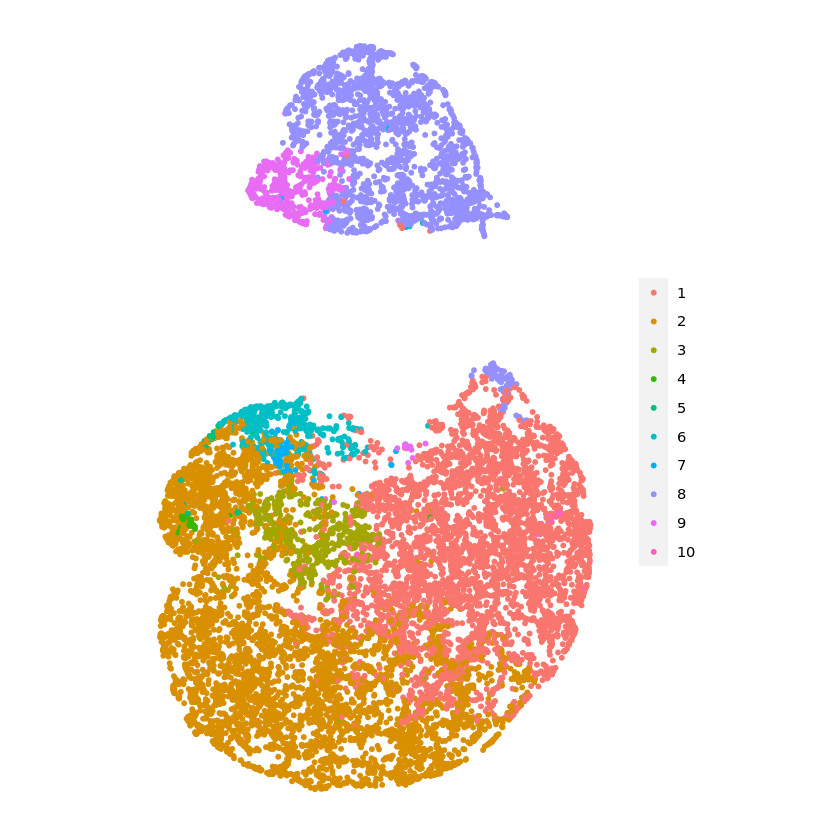

In [11]:
# plot FlowSOM on umap
umap_plot_clust  <- data_sub[,c(umap_cols, "cell_id")] %>% mutate(UMAP1 = umap$UMAP1, UMAP2 = umap$UMAP2) %>% left_join(data_clustered_df[,c("cell_id", "b_cell_clust_new")])

pl_umap_clust <- ggplot(umap_plot_clust, aes(x = UMAP1, y = UMAP2, color = b_cell_clust_new)) +
  geom_point(size = 1) +
  coord_fixed(ratio = 1) +
  theme_very_few
pl_umap_clust


In [12]:
# duplicate B cell cluster column and separate CXCR3+ B cells
data_clustered_df$b_cell_clusters_sep  <- data_clustered_df$b_cell_clusters
data_clustered_df[data_clustered_df[,"b_cell_clust_new"]==9, "b_cell_clusters_sep"]  <- 7

[2023-12-13 14:22:10]  starting umap

[2023-12-13 14:22:10]  creating graph of nearest neighbors



[2023-12-13 14:22:56]  creating initial embedding

[2023-12-13 14:22:58]  optimizing embedding

[2023-12-13 14:23:35]  done

Joining with `by = join_by(cell_id)`


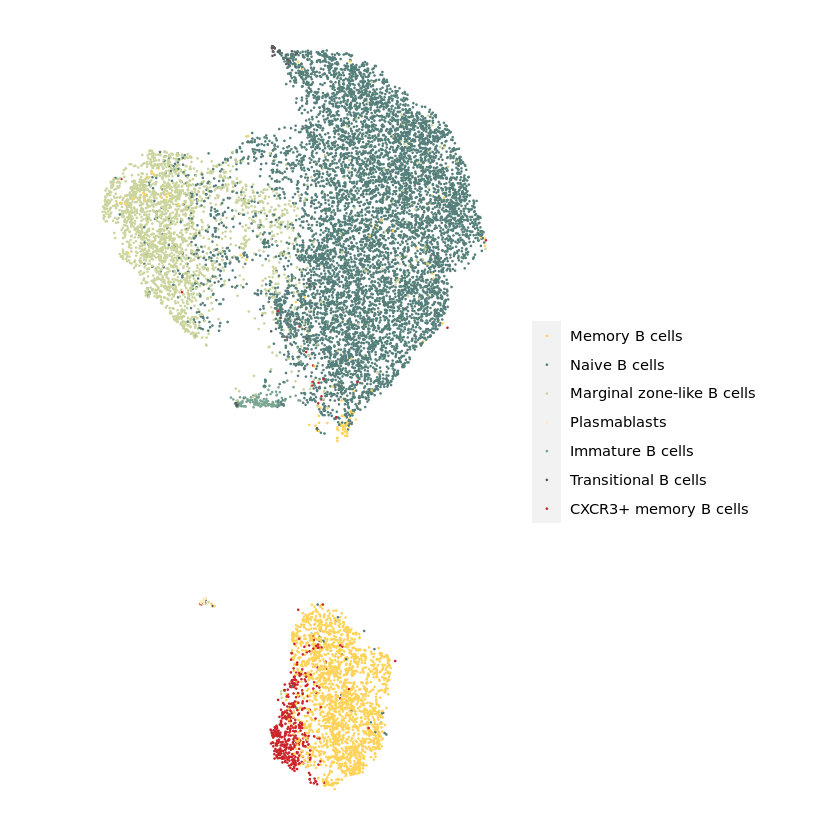

In [14]:
# compute new umap
umap_cols  <- c("IgD", "CXCR3", "CD27", "IgM", 'Ki67', 'CD38', 'CD20', 'HLA-DR', 'CD268', 'CD45RA', 'CCR6')

# UMAP
data_umap <-  umap::umap(data_sub[,umap_cols], random_state=123, verbose =T)
umap <- as.data.frame(data_umap$layout) %>% rename("UMAP1" = 1, "UMAP2" = 2)

# plot umap
clusternames <- c("Memory B cells", "Naive B cells", "Marginal zone-like B cells", "Plasmablasts", "Immature B cells", "Transitional B cells", "CXCR3+ memory B cells")

umap_plot_clust_comb  <- data_sub[,c(umap_cols, "cell_id")] %>% 
                          mutate(UMAP1 = umap$UMAP1, UMAP2 = umap$UMAP2) %>% 
                          left_join(data_clustered_df[,c("cell_id", "b_cell_clust_new", "b_cell_clusters_sep")]) %>%
                          mutate(b_cell_clusters_sep = factor(b_cell_clusters_sep, levels = 1:7, labels = clusternames))


clust_col = c("Memory B cells" = "#FFD258", "Naive B cells" = "#557F7A", "Marginal zone-like B cells" = "#CBD49C", "Plasmablasts"= "#FEEDC3", "Immature B cells" = "#7AA591", "Transitional B cells" = "#5B5B5B", 'CXCR3+ memory B cells' = '#CC242A')

pl_umap_annot <- ggplot(umap_plot_clust_comb, aes(x = UMAP1, y = UMAP2, color = b_cell_clusters_sep)) +
  geom_point(size = 0.1) +
  coord_fixed(ratio = 1) +
  scale_color_manual(values = clust_col) +
  theme_very_few
pl_umap_annot

ggsave(pl_umap_annot, filename = 'figures/B_cells_umap.png', width = 7, height = 5)

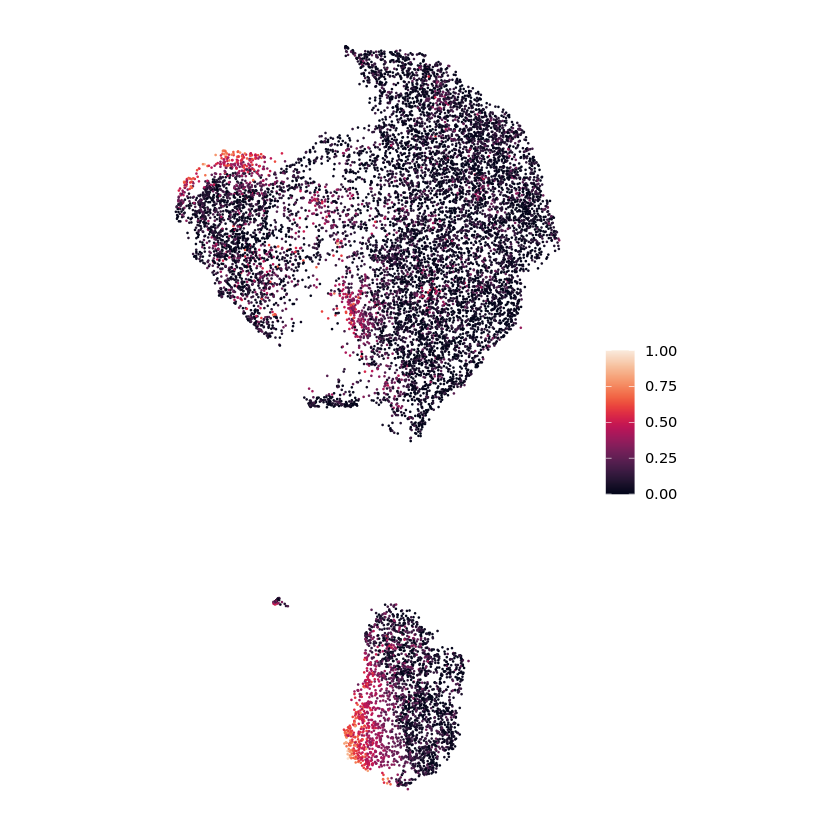

In [15]:
# CXCR3 overlay umap
pl_umap_cxcr3 <- ggplot(umap_plot_clust_comb, aes(x = UMAP1, y = UMAP2, color = CXCR3)) +
  geom_point(size = 0.1) +
  coord_fixed(ratio = 1) +
  scale_colour_gradientn(colours = viridis::rocket(100), limits = c(0,1)) +
  theme_very_few +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())
pl_umap_cxcr3

ggsave(pl_umap_cxcr3, filename = 'figures/CXCR3_umap.png', width = 5, height = 5)

# Median expression and frequencies

In [16]:
# Heatmap of expression profile
markers  <-  colnames(data_clustered_df)[2:(ncol(data_clustered_df)-6)]

clusternames <- c("Memory B cells", "Naive B cells", "Marginal zone-like B cells", "Plasmablasts", "Immature B cells", "Transitional B cells", "CXCR3+ memory B cells")

mat  <- data_clustered_df %>% select(b_cell_clusters_sep, markers) %>% 
            group_by(b_cell_clusters_sep) %>% summarize_all(mean) %>%
            column_to_rownames("b_cell_clusters_sep")

rownames(mat)  <- clusternames            

heat  <- ComplexHeatmap::Heatmap(mat, col = c(viridis::rocket(100)), border = "black", cluster_rows = TRUE, show_column_dend = FALSE)

dev.off()
pdf('figures/B_cells_heatmap.pdf', height = 2.5, width = 10)
heat   
dev.off()         

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(markers)

  # Now:
  data %>% select(all_of(markers))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“The input is a data frame, convert it to a matrix.”


null device 
          1

null device 
          1

In [17]:
# compute frequencies
cluster_freqs  <- data_clustered_df %>% 
                    mutate(b_cell_clusters_sep = factor(b_cell_clusters_sep, labels = clusternames, levels = 1:length(clusternames))) %>% 
                    group_by(sample_id, b_cell_clusters_sep) %>%
                    summarize(B_cell_count = n()) %>% group_by(sample_id) %>%
                    mutate(freq = (B_cell_count/sum(B_cell_count)*100)) %>% right_join(md) %>%
                    mutate(feature_pair = paste(b_cell_clusters_sep, pair)) %>% 
                    left_join(sample_counts) %>% 
                    mutate(freq_total = (B_cell_count/total_count)*100)

complete_feature_pairs  <-  cluster_freqs %>% group_by(feature_pair) %>% summarize(n = n()) %>%
                            filter(n == 2) %>% pull(feature_pair)

untreated_pairs  <- md %>% filter(disease_state == "Multiple Sclerosis" & is.na(DMT)) %>% pull(pair)


cluster_freqs_compl  <-  cluster_freqs %>% 
                        filter(feature_pair %in% complete_feature_pairs & inclusion == 1) %>% 
                        arrange(disease_state, pair, b_cell_clusters_sep)

cluster_freqs_compl_unt  <-  cluster_freqs %>% 
                        filter(feature_pair %in% complete_feature_pairs & inclusion == 1 & pair %in% untreated_pairs) %>% 
                        arrange(disease_state, pair, b_cell_clusters_sep)                        


`summarise()` has grouped output by 'sample_id'. You can override using the
`.groups` argument.
Joining with `by = join_by(sample_id)`
Joining with `by = join_by(sample_id)`


In [19]:
# stats
stats_freq  <- ggpubr::compare_means(freq ~disease_state, data = cluster_freqs_compl, group.by = "b_cell_clusters_sep", method = "wilcox.test", p.adjust.method = "none", paired = TRUE)
stats_freq

stats_freq_unt  <- ggpubr::compare_means(freq ~disease_state, data = cluster_freqs_compl_unt, group.by = "b_cell_clusters_sep", method = "wilcox.test", p.adjust.method = "none", paired = TRUE)
stats_freq_unt

Adding missing grouping variables: `sample_id`


b_cell_clusters_sep,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Memory B cells,freq,Healthy,Multiple Sclerosis,0.008949599,0.00890,0.00895,**,Wilcoxon
Naive B cells,freq,Healthy,Multiple Sclerosis,0.008541906,0.00850,0.00854,**,Wilcoxon
Marginal zone-like B cells,freq,Healthy,Multiple Sclerosis,0.010045841,0.01000,0.01005,*,Wilcoxon
Immature B cells,freq,Healthy,Multiple Sclerosis,0.000628877,0.00063,0.00063,***,Wilcoxon
Transitional B cells,freq,Healthy,Multiple Sclerosis,0.000548103,0.00055,0.00055,***,Wilcoxon
CXCR3+ memory B cells,freq,Healthy,Multiple Sclerosis,0.001842435,0.00180,0.00184,**,Wilcoxon
Plasmablasts,freq,Healthy,Multiple Sclerosis,0.323324561,0.32000,0.32332,ns,Wilcoxon


Adding missing grouping variables: `sample_id`


b_cell_clusters_sep,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Memory B cells,freq,Healthy,Multiple Sclerosis,0.49800873,0.500,0.498,ns,Wilcoxon
Naive B cells,freq,Healthy,Multiple Sclerosis,0.70118141,0.700,0.701,ns,Wilcoxon
Marginal zone-like B cells,freq,Healthy,Multiple Sclerosis,0.84082222,0.840,0.841,ns,Wilcoxon
Plasmablasts,freq,Healthy,Multiple Sclerosis,0.95153809,0.950,0.952,ns,Wilcoxon
Transitional B cells,freq,Healthy,Multiple Sclerosis,0.71189880,0.710,0.712,ns,Wilcoxon
CXCR3+ memory B cells,freq,Healthy,Multiple Sclerosis,0.03276825,0.033,0.033,*,Wilcoxon
Immature B cells,freq,Healthy,Multiple Sclerosis,0.41308594,0.410,0.413,ns,Wilcoxon


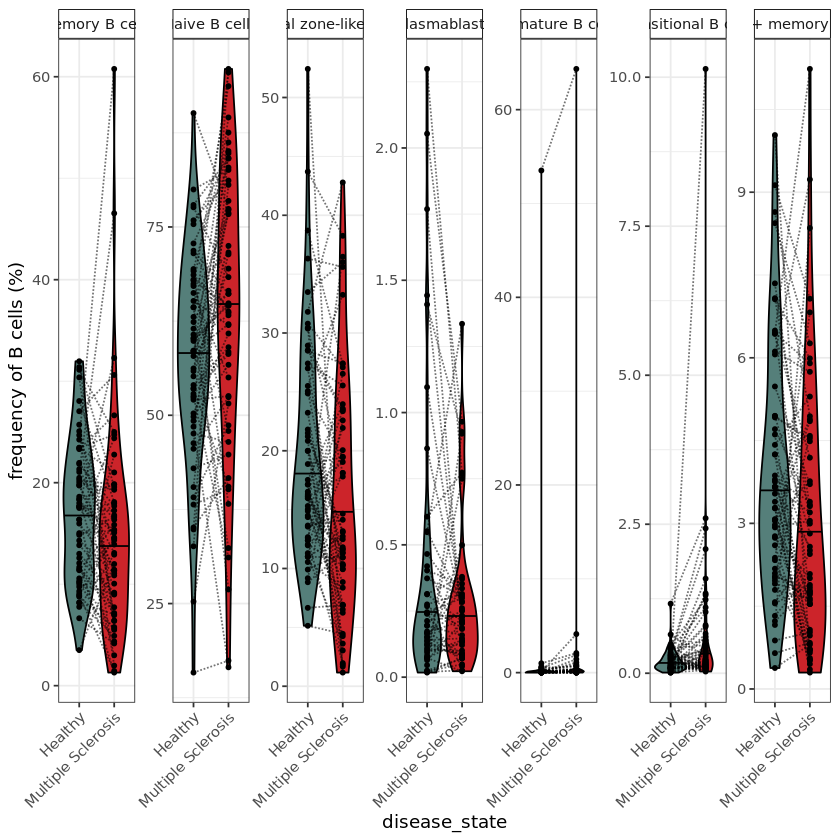

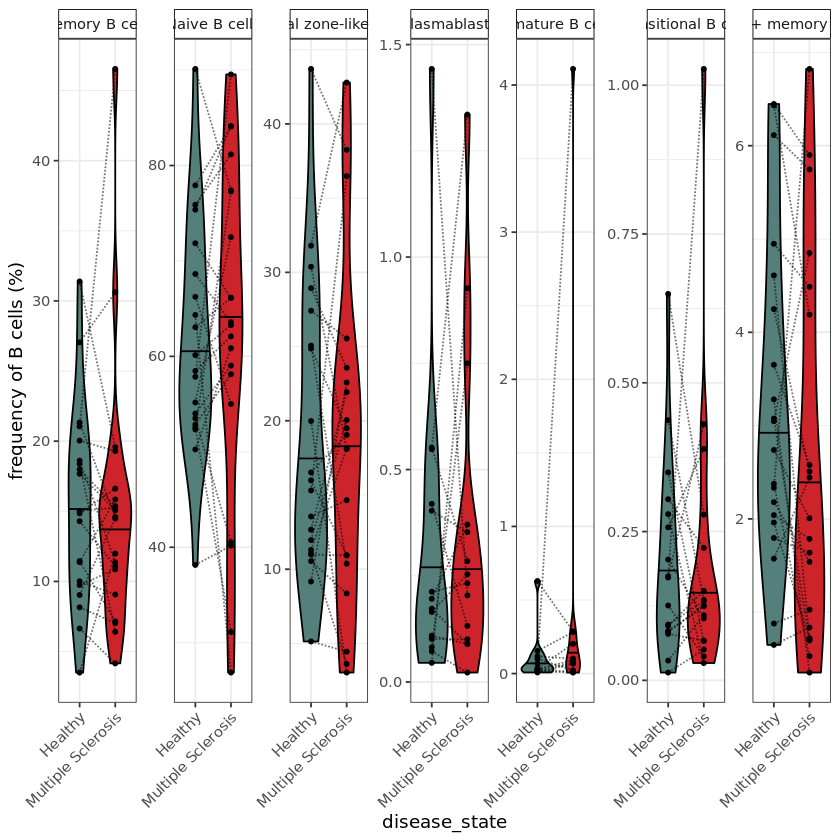

In [20]:
# plot violins
pl_violin_freq <- ggplot(data = cluster_freqs_compl, aes(x=disease_state, y= freq, col= disease_state, fill = disease_state, alpha= 1)) +
  theme_bw() +
  scale_fill_manual(values = c("#557F7A", "#CC242A")) +
  scale_color_manual(values = c("black", "black")) +
  geom_violin(scale="area", aes(fill=disease_state), alpha=1, draw_quantiles = .5) +
  geom_point(size =1, alpha=1) + facet_wrap(~b_cell_clusters_sep, scales = "free", ncol = 9) +
  geom_line(aes(group=pair), colour="black", linetype="11") +
  theme(legend.position = "none",
        strip.background = element_rect(colour = "black", fill = "white"),
        axis.text.x = element_text(angle = 45, hjust = 1))+
  ylab("frequency of B cells (%)")
pl_violin_freq
ggsave(pl_violin_freq, filename = 'figures/Violin_b_cells_incl.pdf', width = 10, height = 3.5)

pl_violin_freq_unt <- ggplot(data = cluster_freqs_compl_unt, aes(x=disease_state, y= freq, col= disease_state, fill = disease_state, alpha= 1)) +
  theme_bw() +
  scale_fill_manual(values = c("#557F7A", "#CC242A")) +
  scale_color_manual(values = c("black", "black")) +
  geom_violin(scale="area", aes(fill=disease_state), alpha=1, draw_quantiles = .5) +
  geom_point(size =1, alpha=1) + facet_wrap(~b_cell_clusters_sep, scales = "free", ncol = 9) +
  geom_line(aes(group=pair), colour="black", linetype="11") +
  theme(legend.position = "none",
        strip.background = element_rect(colour = "black", fill = "white"),
        axis.text.x = element_text(angle = 45, hjust = 1))+
  ylab("frequency of B cells (%)")
pl_violin_freq_unt
ggsave(pl_violin_freq_unt, filename = 'figures/Violin_b_cells_unt.pdf', width = 10, height = 3.5)


# Natalizumab part


Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


b_cell_clusters_sep,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Memory B cells,freq,untreated,IFN,0.062162457,0.0620,0.0622,ns,Wilcoxon
Memory B cells,freq,untreated,ALZ,0.012422360,0.0120,0.0124,*,Wilcoxon
Memory B cells,freq,untreated,NAT,0.096969697,0.0970,0.0970,ns,Wilcoxon
Memory B cells,freq,untreated,DMF,0.138904574,0.1400,0.1389,ns,Wilcoxon
Memory B cells,freq,untreated,GLAT,0.181605190,0.1800,0.1816,ns,Wilcoxon
Memory B cells,freq,untreated,FTY,0.513833992,0.5100,0.5138,ns,Wilcoxon
Memory B cells,freq,untreated,TFM,0.484848485,0.4800,0.4848,ns,Wilcoxon
Naive B cells,freq,untreated,IFN,0.181318704,0.1800,0.1813,ns,Wilcoxon
Naive B cells,freq,untreated,ALZ,0.001129305,0.0011,0.0011,**,Wilcoxon


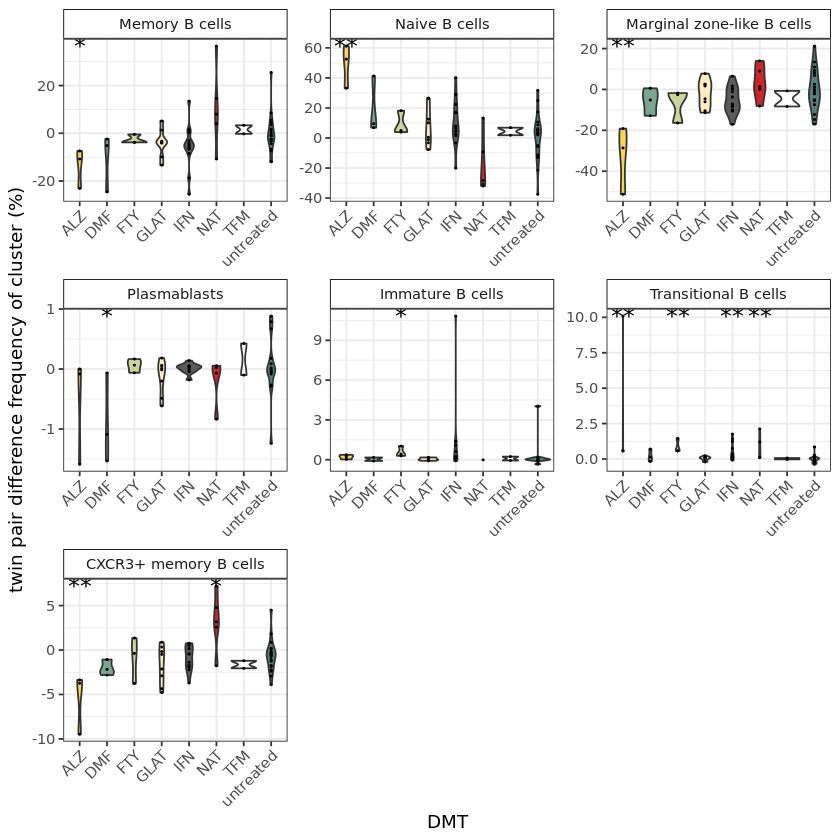

In [22]:
# analyze effect of DMT on B cell clusters
colors_DMT <- c(untreated = "#557F7A", ALZ = "#FFD258", DMF= "#7AA591", FTY = "#CBD49C",  GLAT = "#FEEDC3", IFN = "#5B5B5B", NAT ="#CC242A", TFM= "white")

cluster_freqs_compl_healthy  <- cluster_freqs_compl %>% filter(disease_state == "Healthy") %>% arrange(pair, b_cell_clusters_sep) %>% ungroup

cluster_freqs_compl_delta  <- cluster_freqs_compl %>% filter(disease_state == "Multiple Sclerosis") %>% arrange(pair, b_cell_clusters_sep) %>% ungroup %>% 
                            mutate(freq = (freq - cluster_freqs_compl_healthy$freq), freq_total = (freq_total - cluster_freqs_compl_healthy$freq_total))

cluster_freqs_compl_delta[is.na(cluster_freqs_compl_delta$DMT),"DMT"]  <- "untreated"

pl_delta_DMT_freq_all_subsets <- ggplot(data = cluster_freqs_compl_delta, aes(x=DMT, y= freq, fill = DMT, alpha= 1)) +
  geom_violin(aes(fill=DMT), alpha =1) + facet_wrap(~b_cell_clusters_sep, scales = "free") +
  geom_point(size =.2, alpha=1) +
  theme_bw() +
  scale_fill_manual(values = colors_DMT) +
  ggpubr::stat_compare_means(label = 'p.signif', method = "wilcox.test", paired = FALSE, ref.group = 'untreated', hide.ns = TRUE, label.y.npc = 0.95, size = 5) +
  ylab("twin pair difference frequency of cluster (%)") +
  theme(legend.position = "none",
        strip.background = element_rect(colour = "black", fill = "white"),
        axis.text.x = element_text(angle = 45, hjust = 1))
pl_delta_DMT_freq_all_subsets
ggsave(pl_delta_DMT_freq_all_subsets, filename='figures/DMT_effect_all_clusters.pdf', height = 8, width = 8)

stats_DMT_all  <- ggpubr::compare_means(freq ~DMT, data = cluster_freqs_compl_delta, method = "wilcox.test", group.by = "b_cell_clusters_sep", p.adjust.method = "none", paired = FALSE, ref.group = "untreated")
stats_DMT_all

# Revisions

In [24]:
# compute medians of CCRs within memory B cells
B_mem_Ccr_med  <- data_clustered_df %>% filter(b_cell_clusters == 1) %>% select(CXCR3, CCR4, CCR6, sample_id) %>%
                    group_by(sample_id) %>% summarize_all(median) %>% reshape2::melt(id.vars = 'sample_id', value.name = 'median_expression', variable.name = 'antigen') %>%
                    left_join(md) %>% mutate(feature_pair = paste(antigen, pair))

ccr_med_complete_feature_pairs  <-  B_mem_Ccr_med %>% group_by(feature_pair) %>% summarize(n = n()) %>%
                            filter(n == 2) %>% pull(feature_pair)

B_mem_Ccr_med_compl  <-  B_mem_Ccr_med %>% 
                        filter(feature_pair %in% ccr_med_complete_feature_pairs & inclusion == 1) %>% 
                        arrange(disease_state, pair, antigen)

B_mem_Ccr_med_compl_unt  <-  B_mem_Ccr_med %>% 
                        filter(feature_pair %in% ccr_med_complete_feature_pairs & inclusion == 1 & pair %in% untreated_pairs) %>% 
                        arrange(disease_state, pair, antigen)                                  

Joining with `by = join_by(sample_id)`


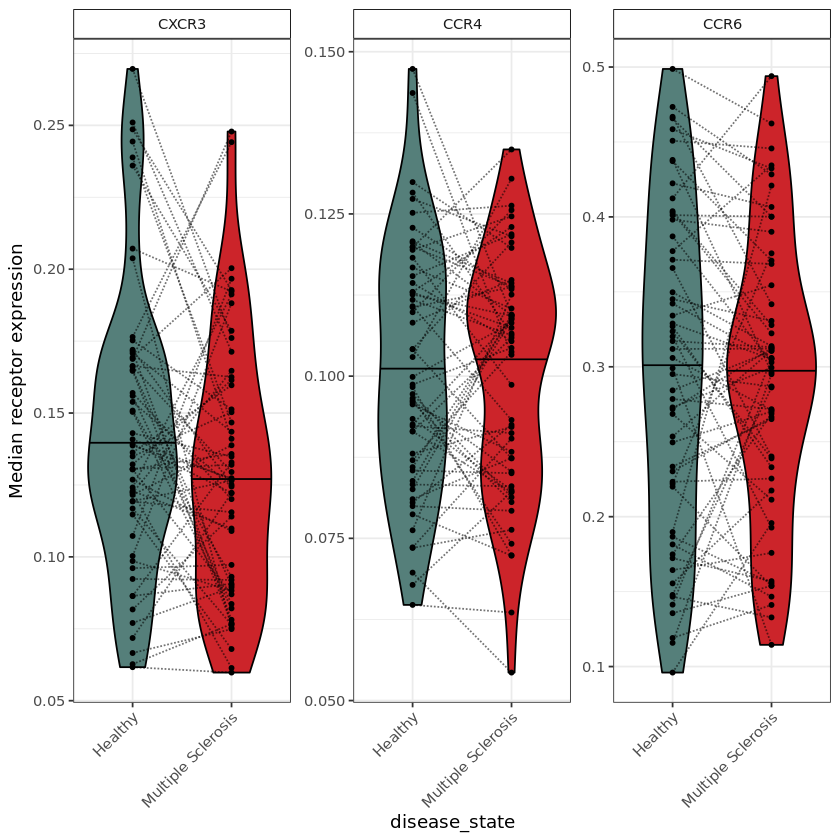

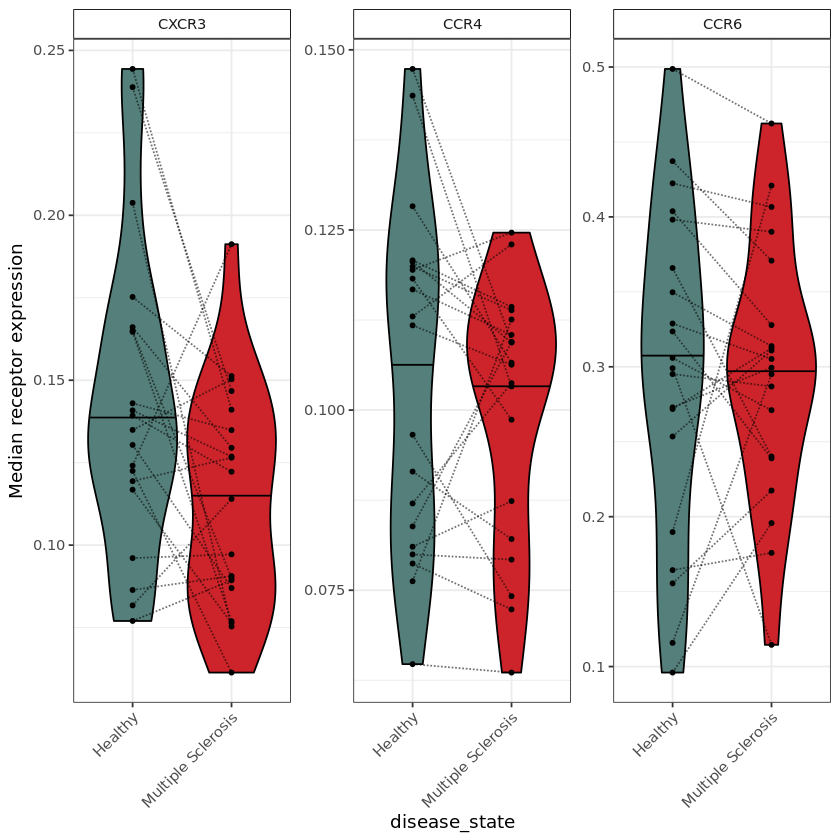

In [25]:
# Plot medians              
pl_violin_ccr_med <- ggplot(data = B_mem_Ccr_med_compl, aes(x=disease_state, y= median_expression, col= disease_state, fill = disease_state, alpha= 1)) +
  theme_bw() +
  scale_fill_manual(values = c("#557F7A", "#CC242A")) +
  scale_color_manual(values = c("black", "black")) +
  geom_violin(scale="area", aes(fill=disease_state), alpha=1, draw_quantiles = .5) +
  geom_point(size =1, alpha=1) + facet_wrap(~antigen, scales = "free", ncol = 9) +
  geom_line(aes(group=pair), colour="black", linetype="11") +
  theme(legend.position = "none",
        strip.background = element_rect(colour = "black", fill = "white"),
        axis.text.x = element_text(angle = 45, hjust = 1))+
  ylab("Median receptor expression")
pl_violin_ccr_med
ggsave(pl_violin_ccr_med, filename = 'figures/Violin_B_mem_CCRs.pdf', width = 5, height = 3.5)

pl_violin_ccr_med_unt <- ggplot(data = B_mem_Ccr_med_compl_unt, aes(x=disease_state, y= median_expression, col= disease_state, fill = disease_state, alpha= 1)) +
  theme_bw() +
  scale_fill_manual(values = c("#557F7A", "#CC242A")) +
  scale_color_manual(values = c("black", "black")) +
  geom_violin(scale="area", aes(fill=disease_state), alpha=1, draw_quantiles = .5) +
  geom_point(size =1, alpha=1) + facet_wrap(~antigen, scales = "free", ncol = 9) +
  geom_line(aes(group=pair), colour="black", linetype="11") +
  theme(legend.position = "none",
        strip.background = element_rect(colour = "black", fill = "white"),
        axis.text.x = element_text(angle = 45, hjust = 1))+
  ylab("Median receptor expression")
pl_violin_ccr_med_unt
ggsave(pl_violin_ccr_med_unt, filename = 'figures/Violin_B_mem_CCRs_unt.pdf', width = 5, height = 3.5)

In [26]:
# stats
stats_ccrs  <- ggpubr::compare_means(median_expression ~disease_state, data = B_mem_Ccr_med_compl, group.by = "antigen", method = "wilcox.test", p.adjust.method = "none", paired = TRUE)
stats_ccrs

stats_ccrs_unt  <- ggpubr::compare_means(median_expression ~disease_state, data = B_mem_Ccr_med_compl_unt, group.by = "antigen", method = "wilcox.test", p.adjust.method = "none", paired = TRUE)
stats_ccrs_unt

antigen,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
CXCR3,median_expression,Healthy,Multiple Sclerosis,0.03456438,0.035,0.035,*,Wilcoxon
CCR4,median_expression,Healthy,Multiple Sclerosis,0.69704300,0.700,0.697,ns,Wilcoxon
CCR6,median_expression,Healthy,Multiple Sclerosis,0.37782110,0.380,0.378,ns,Wilcoxon


antigen,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
CXCR3,median_expression,Healthy,Multiple Sclerosis,0.0192337,0.019,0.019,*,Wilcoxon
CCR4,median_expression,Healthy,Multiple Sclerosis,0.1893482,0.190,0.189,ns,Wilcoxon
CCR6,median_expression,Healthy,Multiple Sclerosis,0.7561665,0.760,0.756,ns,Wilcoxon


In [28]:
FC_dir  <- cluster_freqs_compl_delta %>%
    filter(DMT %in% c('untreated', 'NAT')) %>%
    group_by(b_cell_clusters_sep, DMT) %>%
    summarize(mean = mean(freq)) %>%
    spread(DMT, mean) %>%
    mutate(dir = (untreated - NAT)<0) %>%
    select(b_cell_clusters_sep, dir)

`summarise()` has grouped output by 'b_cell_clusters_sep'. You can override
using the `.groups` argument.


In [29]:
# Compute Wilcoxon effect size for cluster frequencies in response to NAT treatment of B cell subsets
NAT_wilcox_effsize <- cluster_freqs_compl_delta %>%
    filter(DMT %in% c('untreated', 'NAT')) %>%
    group_by(b_cell_clusters_sep) %>%
    wilcox_effsize(formula = freq ~ DMT, paired = FALSE) %>%
    left_join(FC_dir)


Joining with `by = join_by(b_cell_clusters_sep)`


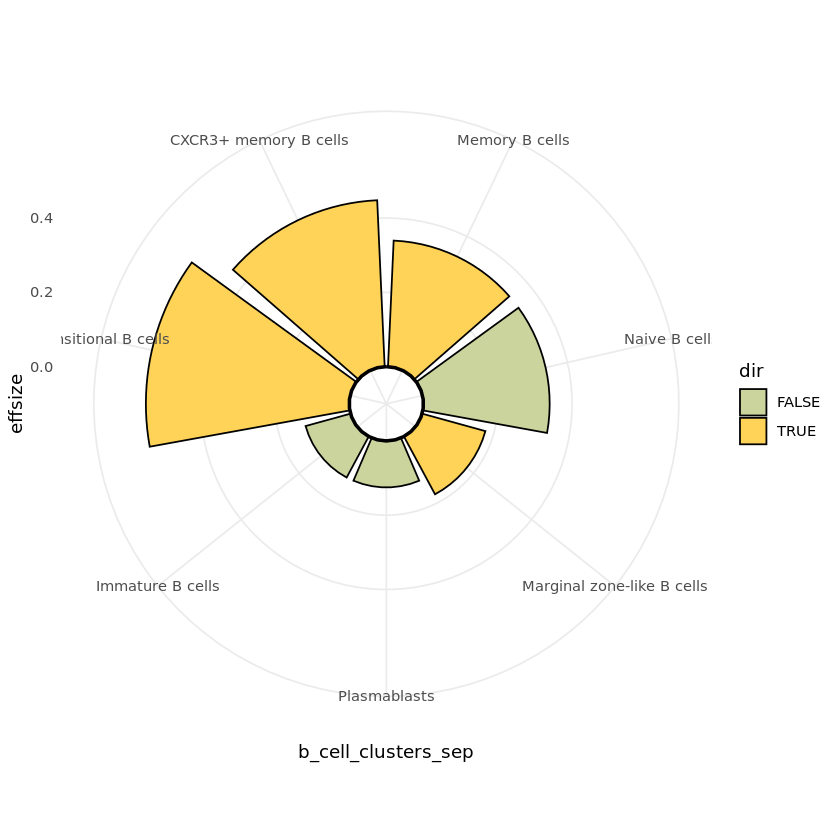

In [31]:
# radar plot
pl_NAT_radar <- ggplot(data=NAT_wilcox_effsize,  aes(x=b_cell_clusters_sep, y=effsize, fill=dir)) + 
  geom_bar(stat="identity", color = 'black')+
  geom_hline(yintercept = 0, color="black", size=1)+
  ylim(-0.1, .6)+
  scale_x_discrete() +
  theme_minimal()+
  scale_fill_manual(values= c("#CBD49C", "#FFD258"))+
  theme(panel.grid.minor = element_blank())+
  coord_polar()
pl_NAT_radar
ggsave(pl_NAT_radar, file="figures/NAT_effect_size_radar.pdf", width=4, height=4, useDingbats=FALSE)


In [32]:
# compare NAT impact on memory B cells
cluster_freqs_CXCR3_bmem  <- data_clustered_df %>% 
                    mutate(b_cell_clusters_sep = factor(b_cell_clusters_sep, labels = clusternames, levels = 1:length(clusternames))) %>%
                    filter(b_cell_clusters_sep %in% c("CXCR3+ memory B cells", "Memory B cells")) %>%
                    group_by(sample_id, b_cell_clusters_sep) %>%
                    summarize(B_cell_count = n()) %>% group_by(sample_id) %>%
                    mutate(freq = (B_cell_count/sum(B_cell_count)*100)) %>% right_join(md) %>%
                    filter(b_cell_clusters_sep == 'CXCR3+ memory B cells')

complete_feature_pairs_CXCR3_bmem  <-  cluster_freqs_CXCR3_bmem %>% group_by(pair) %>% summarize(n = n()) %>%
                            filter(n == 2) %>% pull(pair)

cluster_freqs_CXCR3_bmem_compl  <-  cluster_freqs_CXCR3_bmem %>% 
                        filter(pair %in% complete_feature_pairs_CXCR3_bmem & inclusion == 1) %>% 
                        arrange(disease_state, pair)                                                

`summarise()` has grouped output by 'sample_id'. You can override using the
`.groups` argument.
Joining with `by = join_by(sample_id)`


In [33]:
# compute delta
cluster_freqs_CXCR3_bmem_compl_healthy  <- cluster_freqs_CXCR3_bmem_compl %>% filter(disease_state == "Healthy") %>% arrange(pair) %>% ungroup

cluster_freqs_CXCR3_bmem_compl_delta  <- cluster_freqs_CXCR3_bmem_compl %>% filter(disease_state == "Multiple Sclerosis") %>% arrange(pair) %>% ungroup %>% 
                            mutate(freq = (freq - cluster_freqs_CXCR3_bmem_compl_healthy$freq))

cluster_freqs_CXCR3_bmem_compl_delta[is.na(cluster_freqs_CXCR3_bmem_compl_delta$DMT),"DMT"]  <- "untreated"

.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
freq,untreated,IFN,0.11840918,0.120,0.118,ns,Wilcoxon
freq,untreated,ALZ,0.69791078,0.700,0.698,ns,Wilcoxon
freq,untreated,NAT,0.08322981,0.083,0.083,ns,Wilcoxon
freq,untreated,DMF,0.63466968,0.630,0.635,ns,Wilcoxon
freq,untreated,GLAT,0.63577196,0.640,0.636,ns,Wilcoxon
freq,untreated,FTY,0.23037832,0.230,0.230,ns,Wilcoxon
freq,untreated,TFM,0.42424242,0.420,0.424,ns,Wilcoxon


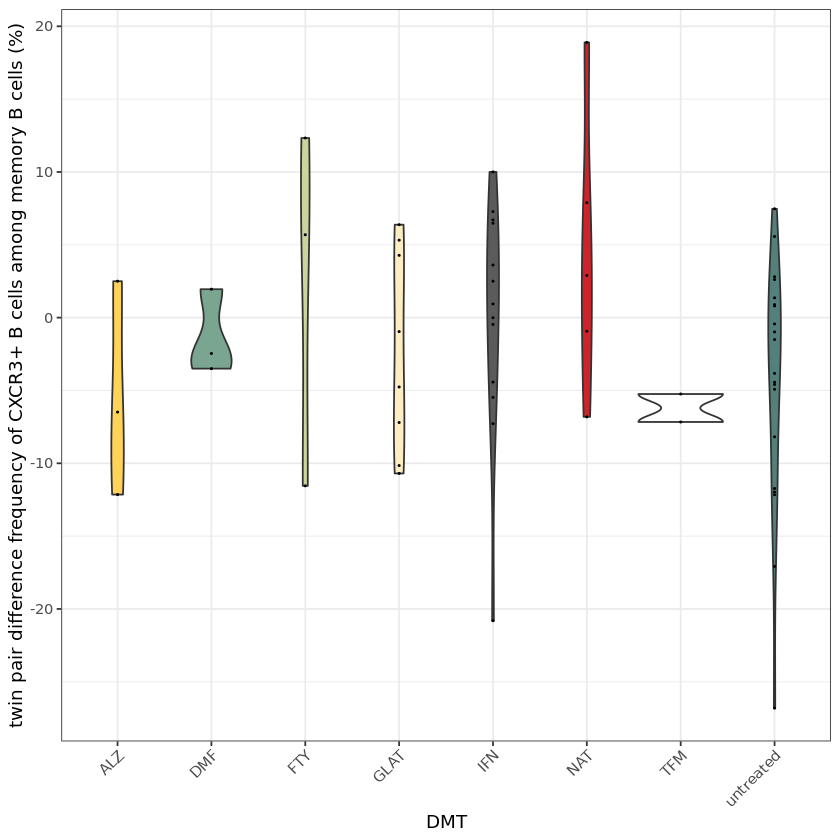

In [34]:
# plot
pl_delta_DMT_freq_CXCR3_bmem <- ggplot(data = cluster_freqs_CXCR3_bmem_compl_delta, aes(x=DMT, y= freq, fill = DMT, alpha= 1)) +
                                        geom_violin(aes(fill=DMT), alpha =1) + 
                                        geom_point(size =.2, alpha=1) +
                                        theme_bw() +
                                        scale_fill_manual(values = colors_DMT) +
                                        ggpubr::stat_compare_means(label = 'p.signif', method = "wilcox.test", paired = FALSE, ref.group = 'untreated', hide.ns = TRUE, label.y.npc = 0.95, size = 5) +
                                        ylab("twin pair difference frequency of CXCR3+ B cells among memory B cells (%)") +
                                        theme(legend.position = "none",
                                            strip.background = element_rect(colour = "black", fill = "white"),
                                            axis.text.x = element_text(angle = 45, hjust = 1))
pl_delta_DMT_freq_CXCR3_bmem
ggsave(pl_delta_DMT_freq_CXCR3_bmem, filename='figures/DMT_effect_CXCR3_Bmem.pdf', height = 2.5, width = 3)

stats_CXCR3_bmem  <- ggpubr::compare_means(freq ~DMT, data = cluster_freqs_CXCR3_bmem_compl_delta, method = "wilcox.test", p.adjust.method = "none", paired = FALSE, ref.group = "untreated")
stats_CXCR3_bmem